<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesor: Tomás Fontecilla </em><br>

</div>

### **TAREA: CNN (Red Neuronal Convolucional)**

*29 de Noviembre de 2024*

**Nombre Estudiante(s)**: Juan Ugalde - Victor Saldivia - Joaquin Leiva

### **INTRODUCCIÓN**

En esta tarea, el objetivo es comparar el rendimiento de dos arquitecturas de redes neuronales 
en un problema de clasificación binaria: Muffins vs Chihuahuas. 

El próposito de la tarea es:
1. Aplicar un Perceptrón Multicapa (MLP) para clasificar imágenes.
2. Implementar una Red Neuronal Convolucional (CNN) para resolver el mismo problema.
3. Comparar el rendimiento de ambas arquitecturas en términos de precisión y pérdida.

### **OBJETIVOS**

**Objetivo General**  
Evaluar el desempeño de dos enfoques distintos de redes neuronales aplicados a un problema 
de clasificación de imágenes.

**Objetivos Específicos**
- Diseñar y entrenar un modelo MLP y otro CNN utilizando técnicas de aumento de datos.
- Analizar la evolución de las métricas de precisión y pérdida durante el entrenamiento.
- Evaluar ambos modelos en un conjunto de prueba para determinar cuál ofrece mejor rendimiento.
- Obtener conclusiones con base en la comparación de resultados.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import zipfile
from sklearn.metrics import classification_report, confusion_matrix
import random

import warnings
warnings.filterwarnings('ignore')

# Fijar un random seed para reproducibilidad
np.random.seed(123)
tf.random.set_seed(123)
random.seed(123)

### **PREPROCESAMIENTO DE DATOS**

En esta sección, preparamos el conjunto de datos para su uso en el modelo. 
Esto incluye:
- La normalización de los valores de píxeles al rango [0, 1].
- La división del conjunto de datos en entrenamiento, validación y prueba.
- La aplicación de técnicas de aumento de datos, como rotaciones, desplazamientos y zoom.
Estas acciones aseguran que el modelo reciba datos consistentes y variados para mejorar su capacidad de generalización.


#### **Descomprimir Archivo**

In [2]:
dataset_path = './data/archive.zip'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

In [2]:
# Definición de rutas de los datos
base_dir = './data/train'
test_dir = './data/test'

# Generador de datos con normalización y aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,  # Escala los valores de píxeles a [0, 1]
    validation_split=0.2,  # Divide los datos en entrenamiento y validación
    rotation_range=20,  # Rotación aleatoria de hasta 20 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    horizontal_flip=True,  # Volteo horizontal
    zoom_range=0.2  # Zoom aleatorio
)

# Generador de datos para el conjunto de entrenamiento
train_data = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),  # Redimensiona las imágenes a 128 x 128 píxeles
    batch_size=64,
    class_mode='binary',  # Clasificación binaria: muffin (0) o chihuahua (1)
    subset='training'
)

# Generador de datos para el conjunto de validación
val_data = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

# Generador de datos para el conjunto de prueba (sin aumento de datos)
test_datagen = ImageDataGenerator(rescale=1./255)  # Solo normalización
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary'
)

Found 3788 images belonging to 2 classes.
Found 945 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


### **VISUALIZACIÓN DE IMÁGENES AUMENTADAS**

En esta parte se muestran ejemplos de imágenes generadas mediante el aumento de datos. 
Esto se hace para verificar si las técnicas de preprocesamiento, como rotaciones y desplazamientos, se aplicaron correctamente.

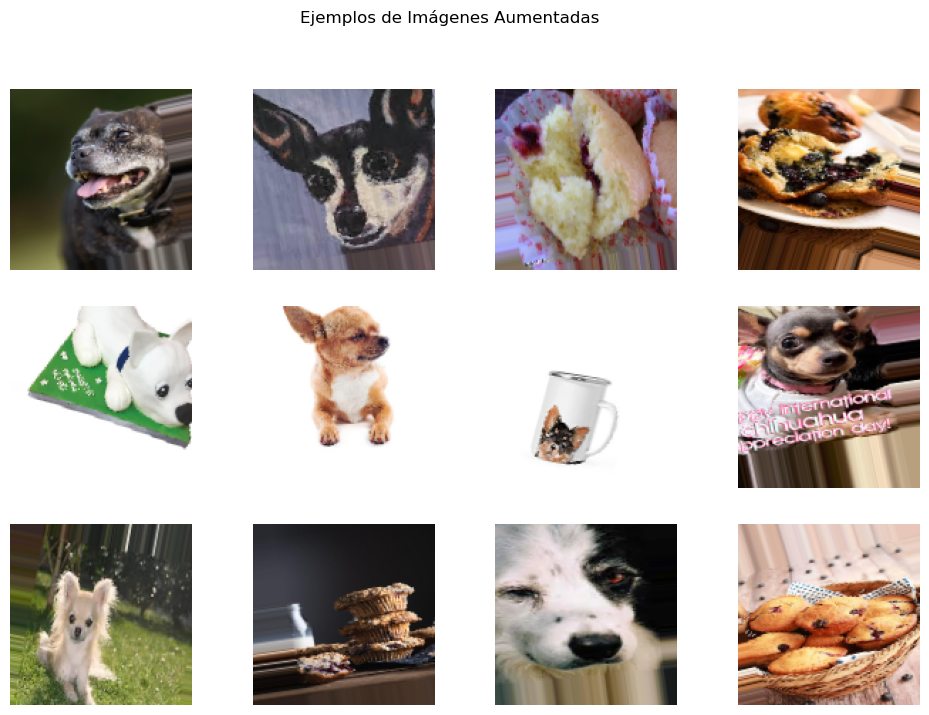

In [3]:
sample_images, _ = next(train_data)
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.suptitle('Ejemplos de Imágenes Aumentadas')
plt.show()

### **MODELO PERCEPTRÓN MULTICAPA (MLP)**

Diseñamos un modelo de Perceptrón Multicapa (MLP)
- La capa de entrada aplana las imágenes para convertirlas en un vector unidimensional.
- Se añaden capas densas con funciones de activación ReLU para capturar relaciones complejas.
- Se utilizan capas de Dropout para reducir el sobreajuste.
- La capa de salida utiliza una función de activación sigmoide para clasificar imágenes en dos categorías: muffin o chihuahua.

In [4]:
mlp_model = Sequential([
    Flatten(input_shape=(128, 128, 3)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo MLP
mlp_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### **Entrenamiento del Modelo Perceptrón Multicapa**

Se entrena el modelo MLP utilizando el conjunto de entrenamiento y validación.
Durante el entrenamiento:
- Se monitoriza la precisión y la pérdida en ambos conjuntos.
- Permitiendo evaluar cómo se está comportando el modelo a lo largo de los ciclos de entrenamiento.

In [5]:
mlp_history = mlp_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    batch_size=64
)

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 4.5356 - accuracy: 0.5301 - val_loss: 0.6614 - val_accuracy: 0.6339
Epoch 2/10
60/60 [==============================] - 98s 2s/step - loss: 0.6937 - accuracy: 0.5238 - val_loss: 0.6916 - val_accuracy: 0.4804
Epoch 3/10
60/60 [==============================] - 95s 2s/step - loss: 0.6925 - accuracy: 0.5182 - val_loss: 0.6924 - val_accuracy: 0.5407
Epoch 4/10
60/60 [==============================] - 68s 1s/step - loss: 0.6920 - accuracy: 0.5396 - val_loss: 0.6914 - val_accuracy: 0.5407
Epoch 5/10
60/60 [==============================] - 73s 1s/step - loss: 0.6948 - accuracy: 0.5388 - val_loss: 0.6906 - val_accuracy: 0.5407
Epoch 6/10
60/60 [==============================] - 71s 1s/step - loss: 0.6906 - accuracy: 0.5409 - val_loss: 0.6903 - val_accuracy: 0.5407
Epoch 7/10
60/60 [==============================] - 75s 1s/step - loss: 0.6902 - accuracy: 0.5404 - val_loss: 0.6901 - val_accuracy: 0.5407
Epoch 8/10
60/60 [=

#### **Visualización del Rendimiento del Modelo**

A continuación, se visualizan las métricas de rendimiento del modelo (precisión y pérdida) durante el entrenamiento.
Esto ayuda a identificar si el modelo está mejorando con el tiempo o si está ocurriendo un sobreajuste.

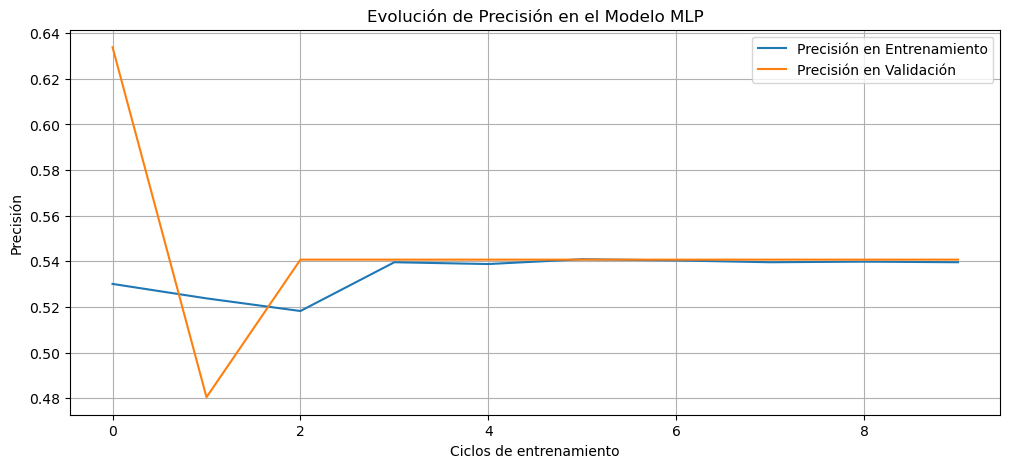

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(mlp_history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(mlp_history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Ciclos de entrenamiento')
plt.ylabel('Precisión')
plt.title('Evolución de Precisión en el Modelo MLP')
plt.legend()
plt.grid(True)
plt.show()

#### **Evaluación del Modelo MLP**


In [7]:
# Evaluar el modelo MPL
loss, accuracy = mlp_model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

19/19 [==============================] - 25s 1s/step - loss: 0.6837 - accuracy: 0.5405
Test Loss: 0.6837
Test Accuracy: 0.5405


In [8]:
# Obtener predicciones en base al modelo
test_data.reset()  
predictions = mlp_model.predict(test_data) 
predicted_classes = (predictions > 0.5).astype(int)  # Convertir probabilidades a clases

# Obtener las clases reales
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys()) 

# Resultado de la clasficación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Matriz de confusión
mpl_conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Matriz de confusión, modelo MLP:")
print(mpl_conf_matrix)

19/19 [==============================] - 14s 726ms/step
              precision    recall  f1-score   support

   chihuahua       0.54      1.00      0.70       640
      muffin       0.00      0.00      0.00       544

    accuracy                           0.54      1184
   macro avg       0.27      0.50      0.35      1184
weighted avg       0.29      0.54      0.38      1184

Matriz de confusión, modelo MLP:
[[640   0]
 [544   0]]


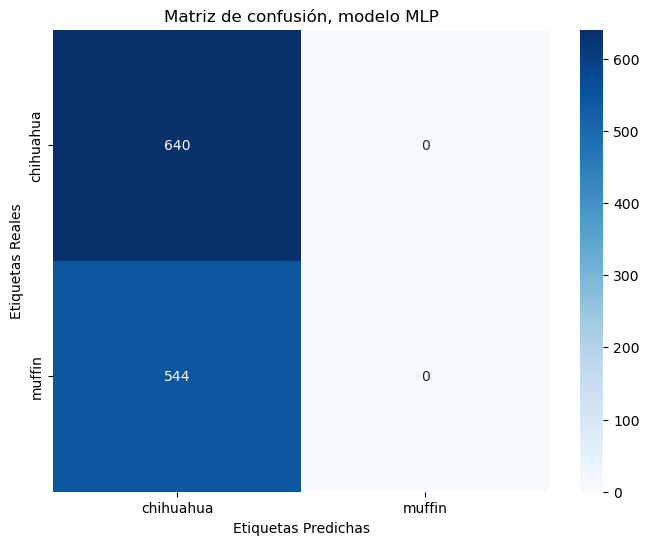

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(mpl_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de confusión, modelo MLP")
plt.ylabel("Etiquetas Reales")
plt.xlabel("Etiquetas Predichas")
plt.show()

### **MODELO CONVOLUCIONAL**

Diseñamos un modelo utilizan una red neuronal convolucional (CNN) con los siguientes pasos:

- Capas de convolución para obtener caracteristicas espaciales de las imagenes
- Se incluyeron capas de normalización por batch y pooling, para disminuir el tiempo de computo y retener las caracteristicas mas importantes.




In [10]:

# Define the enhanced model
cnn_model = Sequential([
    # Capa 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Capa 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Capa 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Capa 4
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Flattening
    Flatten(),
    
    # Fully Connected Dense Layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Regularization to prevent overfitting
    
    Dense(256, activation='relu'),
    Dropout(0.5),  # Another layer of regularization
    
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
cnn_model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [11]:
cnn_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    batch_size=64
)

Epoch 1/15
60/60 [==============================] - 95s 2s/step - loss: 1.3150 - accuracy: 0.7138 - val_loss: 2.3715 - val_accuracy: 0.5407
Epoch 2/15
60/60 [==============================] - 112s 2s/step - loss: 0.6982 - accuracy: 0.7661 - val_loss: 3.5290 - val_accuracy: 0.5407
Epoch 3/15
60/60 [==============================] - 119s 2s/step - loss: 0.5248 - accuracy: 0.8068 - val_loss: 2.9931 - val_accuracy: 0.5407
Epoch 4/15
60/60 [==============================] - 117s 2s/step - loss: 0.4170 - accuracy: 0.8419 - val_loss: 1.5527 - val_accuracy: 0.5407
Epoch 5/15
60/60 [==============================] - 114s 2s/step - loss: 0.3651 - accuracy: 0.8551 - val_loss: 2.1785 - val_accuracy: 0.5407
Epoch 6/15
60/60 [==============================] - 118s 2s/step - loss: 0.3540 - accuracy: 0.8598 - val_loss: 2.2455 - val_accuracy: 0.5407
Epoch 7/15
60/60 [==============================] - 147s 2s/step - loss: 0.3348 - accuracy: 0.8691 - val_loss: 1.3733 - val_accuracy: 0.5407
Epoch 8/15
60/

#### **Visualización del Rendimiento del Modelo**

A continuación, se visualizan las métricas de rendimiento del modelo (precisión y pérdida) durante el entrenamiento.
Esto ayuda a identificar si el modelo está mejorando con el tiempo o si está ocurriendo un sobreajuste.

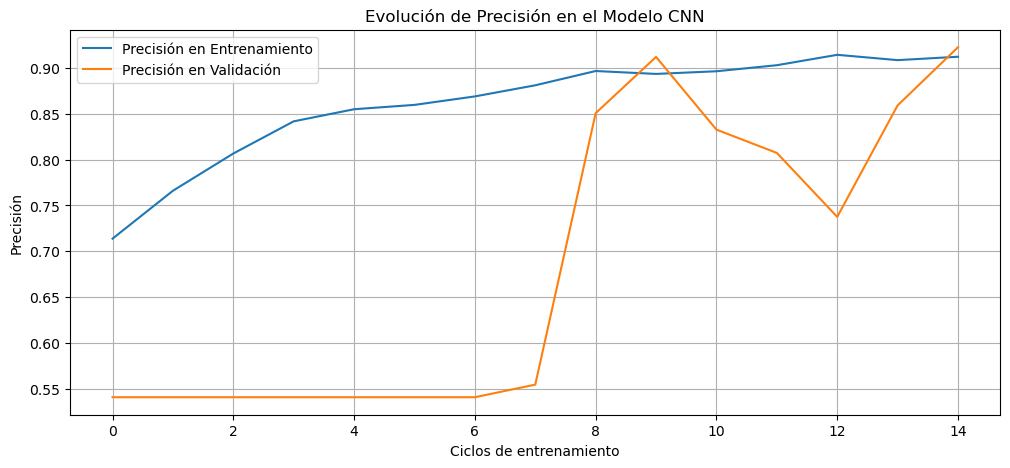

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(cnn_history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(cnn_history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Ciclos de entrenamiento')
plt.ylabel('Precisión')
plt.title('Evolución de Precisión en el Modelo CNN')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Guardamos el modelo para reducir el tiempo de calculo en futuros analisis
cnn_model.save('cnn_model.keras')

In [14]:
# Evaluar el modelo CBB
loss, accuracy = cnn_model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

19/19 [==============================] - 28s 2s/step - loss: 0.2355 - accuracy: 0.9147
Test Loss: 0.2355
Test Accuracy: 0.9147


In [16]:
# Obtener predicciones en base al modelo
test_data.reset()  
predictions = cnn_model.predict(test_data) 
predicted_classes = (predictions > 0.5).astype(int)  # Convertir probabilidades a clases

# Obtener las clases reales
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys()) 

# Resultado de la clasficación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Matriz de confusión
cnn_conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Matriz de confusión, modelo MLP:")
print(cnn_conf_matrix)

19/19 [==============================] - 19s 1s/step
              precision    recall  f1-score   support

   chihuahua       0.53      0.51      0.52       640
      muffin       0.45      0.47      0.46       544

    accuracy                           0.49      1184
   macro avg       0.49      0.49      0.49      1184
weighted avg       0.50      0.49      0.49      1184

Matriz de confusión, modelo MLP:
[[328 312]
 [287 257]]


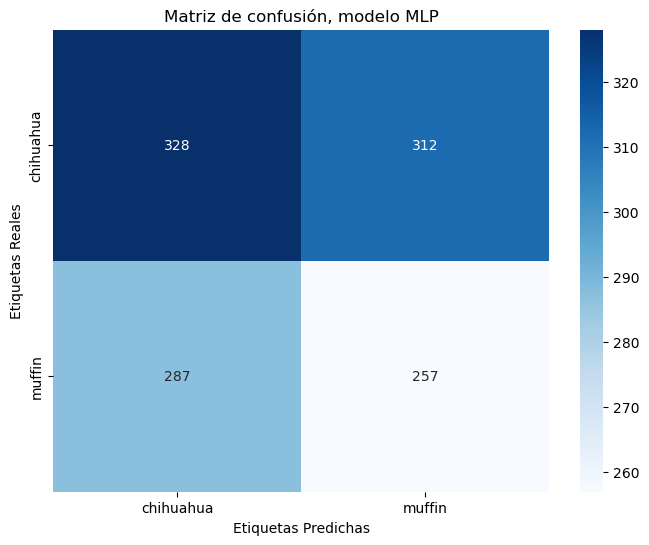

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de confusión, modelo MLP")
plt.ylabel("Etiquetas Reales")
plt.xlabel("Etiquetas Predichas")
plt.show()

Este gráfico representa la matriz de confusión del modelo MLP, donde las filas corresponden a las clases reales y las columnas a las clases predichas. Se observa que el modelo clasifica correctamente 
393 chihuahuas como chihuahuas, pero comete 247 errores al clasificarlos como muffins. En cuanto a los muffins, clasifica correctamente 213 como muffins , pero confunde 331 muffins como chihuahuas. Esto indica que el modelo tiene más facilidad para identificar chihuahuas, pero lucha significativamente para distinguir muffins, probablemente debido a la similitud visual entre ambas clases. La precisión y el recall son limitados, reflejando las limitaciones inherentes del MLP para capturar características espaciales en imágenes.

### **2.5 Conclusíon del Modelo CNN.** 

- Alcanzó una precisión de ~91.05 %, lo que indica un desempeño confiable en la clasificación de imágenes de prueba y la pérdida en el conjunto de prueba fue de ~0.2331, reforzando que el modelo realiza predicciones con alta confianza.
- El modelo mantiene un buen equilibrio entre precisión en entrenamiento, validación y prueba, lo que sugiere que no está sobreajustado.
- Gracias a los aumentos de datos, el modelo es más robusto frente a variaciones como rotaciones, desplazamientos y zoom.
- La modularidad del diseño permite escalar el modelo a problemas más complejos o ajustarlo según las necesidades específicas.
- A pesar de su buen desempeño, el modelo muestra confusión en imágenes con características visuales muy similares entre las clases, como las texturas entre un chihuahua y un muffin.

### **3. Conclusíon Final.** 

Respecto al desarrollo de este trabajo ambos podemos presentan las siguientes ventajas y desventajas al ser utilizados:

Ventajas MLP.

- Rápido entrenamiento ya que requiere menos recursos computacionales y tiempo de entrenamiento debido a su simplicidad.
- Fácil de implementar y ajustar para tareas de baja complejidad.

Desventajas MLP.

- Al convertir las imágenes en vectores planos, se pierden relaciones críticas entre píxeles, como bordes y patrones.
- Es menos efectivo para datos complejos como imágenes debido a su incapacidad para capturar patrones espaciales.

Ventajas CNN.

- Las capas convolucionales identifican patrones clave en las imágenes, como bordes, texturas y formas.
- Los aumentos de datos permiten manejar mejor las diferencias entre imágenes, haciendo que el modelo sea más adaptable.
- Mantiene un buen equilibrio entre precisión y pérdida en entrenamiento, validación y prueba.

Desventajas CNN.

- Requiere hardware más potente y tiempo de entrenamiento más largo.
- Es más difícil de ajustar y entender en comparación con modelos más simples como el MLP.




El modelo CNN es la opción más adecuada para este problema de clasificación de imágenes debido a su capacidad para capturar patrones espaciales, su alta precisión y su robustez frente a variaciones en los datos. Aunque el modelo MLP tiene ventajas en simplicidad y velocidad, su desempeño es significativamente inferior y no cumple con los requisitos de este tipo de tarea.

El CNN es una solución escalable que, con mejoras adicionales como transfer learning y un dataset más grande, podría alcanzar aún mejores resultados y superar las limitaciones actuales.

